
## Indigitall - Pablo Fernandez Ibañez


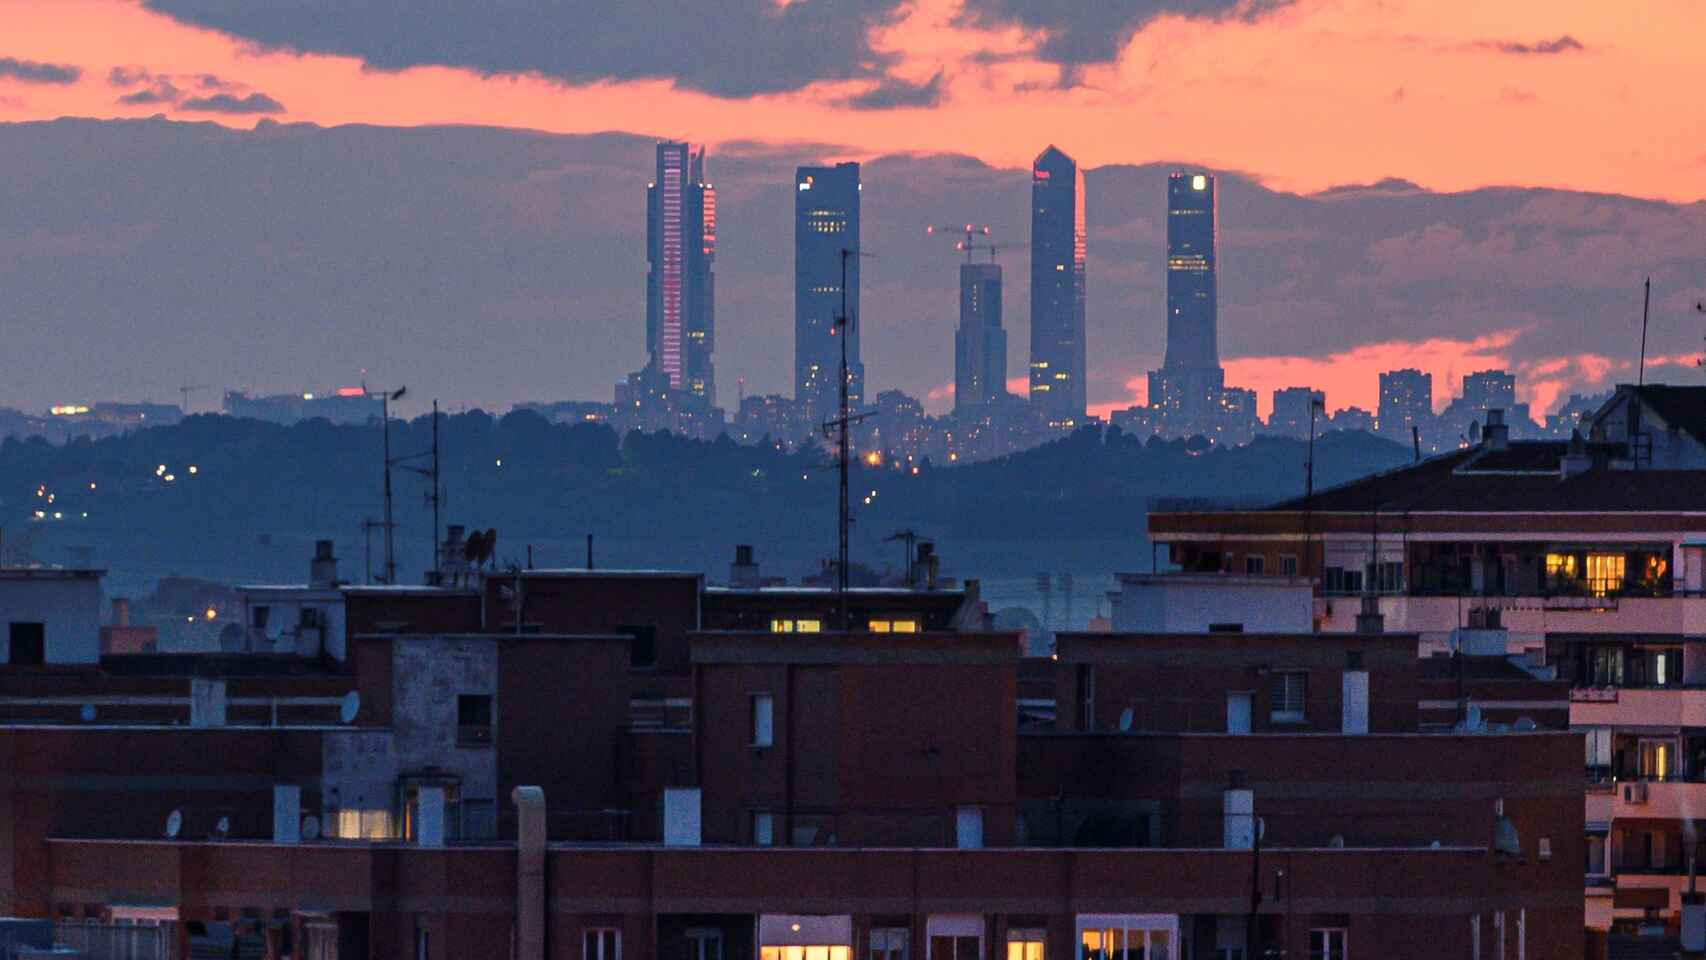

In [4]:
from IPython.display import Image
Image('imagen_prueba.jpg')

### Objetivo del trabajo

En el presente informe estudiaremos los datos del Sistema Integral de la Calidad del Aire del Ayuntamiento de Madrid, que permite saber los niveles de contaminación atmosferica en el municipio
La plataforma ofrece datos tanto horarios como diarios desde 2001 hasta 2021.
 Nuestro punto de vista en este trabajo sera dejar los datos limpios y estructurados para que otros departamentos puedan trabajar con ellos sin ningun problema.
Para ello, solo se tendra en cuenta los datos diarios del año 2018, los objetivos seran los siguientes:
- EDA 
- Feature Engineering
- Propuestas de modelos

Se ha propuesto hacer este trabajo en dos dias para que sea semejante a un ritmo de trabajo laboral normal, se puede ampliar o mejorar dicho trabajo a peticion.
- Para salvar dependecias no se utilizaran caracteres, tildes, n con virgulilla etc

### Datos

Los datos de calidad de aire de Madrid estan disponibles para uso público, la contaminación del aire esta monitoreada por 24 estaciones remotas ubicadas en toda la ciudad.
Se tiene distintas columnas la provincia en este caso, Madrid.
- Municipios
- Provincias
- Magnitud, Solo tendremos en cuenta (Elemento contaminante) NO2.
- Estacion 
- D01-D31, cada dia del mes
- V01-V31 indica si la medicion fue valida ('V', valida, 'N', lo contrario)

### Importación de datos y preprocesamiento inicial

- Librerias

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import warnings

from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Tamaño de la fuente
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

In [6]:
# Tamaño de la fuente
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

- leemos los datos

In [7]:
df_complete = pd.read_csv('datos_diarios_2018.csv', sep=';')
df_temperature = pd.read_csv('madrid_hourly_temperatures_2018.csv')

Procedemos al tratamiento de la temperatura como variable exogena al modelo y lo retomaremos mas adelante

In [8]:
df_temperature = df_temperature.drop(['hour'], axis=1)


In [9]:
df_temperature = df_temperature.rename(columns={'date':'fecha', 'temp':'temperatura'})
df_temperature['fecha'] = pd.to_datetime(df_temperature['fecha'], format='%Y-%m-%d')
df_temperature = df_temperature.set_index('fecha')


In [10]:
df_temperature_media = df_temperature.resample("D").mean()


El siguiente csv se estructura de la siguiente forma:

In [11]:
df_complete.head(5)

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,D02,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,28,79,4,1,28079004_1_38,2018,1,1.0,V,1.0,...,2.0,V,2.0,V,6.0,V,5.0,V,6.0,V
1,28,79,4,1,28079004_1_38,2018,2,5.0,V,3.0,...,3.0,V,2.0,V,0.0,N,0.0,N,0.0,N
2,28,79,4,1,28079004_1_38,2018,3,1.0,V,2.0,...,2.0,V,4.0,V,2.0,V,2.0,V,2.0,V
3,28,79,4,1,28079004_1_38,2018,4,2.0,V,3.0,...,1.0,V,2.0,V,2.0,V,2.0,V,0.0,N
4,28,79,4,1,28079004_1_38,2018,5,2.0,V,2.0,...,2.0,V,2.0,V,3.0,V,2.0,V,2.0,V


Convertimos las columnas en minuscula

In [12]:
df_complete = df_complete.rename(columns=str.lower)

In [13]:
print("Existen", df_complete.shape[0], "filas")
print("Existen", df_complete.shape[1], "columnas")

Existen 1806 filas
Existen 69 columnas


Estudiamos valores nulos y duplicados

In [14]:
print("Existen", df_complete.duplicated().sum(), "valores duplicados")
print('-------------------------------------------------------')
print(df_complete.isnull().sum())
print('valores Nan')

Existen 0 valores duplicados
-------------------------------------------------------
provincia         0
municipio         0
estacion          0
magnitud          0
punto_muestreo    0
                 ..
v29               0
d30               0
v30               0
d31               0
v31               0
Length: 69, dtype: int64
valores Nan


Contamos que elementos quimicos existen en mayor cantidad

In [15]:
df_complete['magnitud'].value_counts()

7     288
8     288
12    288
14    168
10    144
1     120
6     120
20     72
30     72
35     72
9      66
42     36
43     36
44     36
Name: magnitud, dtype: int64

Nos quedamos con las filas que contengan el '8' en la columna magnitud (NO2)

In [16]:
df_no2 = df_complete[(df_complete['magnitud']) == 8]

Analizamos por una parte las mediciones diarias y por otro lado los dias validos
- Transformaremos los datos que son validos como nulos

In [17]:
dia = df_no2.filter(regex=("d."))
validez = df_no2.filter(regex=("^v"))

reemplazaremos los días validos por NaN

In [18]:
validez_null = validez.replace('V',np.nan)
validez_null

,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


Cambiamos los nombres de validez por los nombres de la columna dia

In [19]:
validez_null.columns = dia.columns

Usamos la funcion 'combine_first' que nos permite completar valores nulos de un dataframe por otro dataframe con valores no nulos y sustituirlos

In [20]:
datos_validos = validez_null.combine_first(dia)
datos_validos

,d01,d02,d03,d04,d05,d06,d07,d08,d09,d10,...,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31
36,21.0,29.0,35.0,26.0,32.0,29.0,33.0,54.0,53.0,44.0,...,54.0,57.0,62.0,46.0,38.0,26.0,22.0,67.0,61.0,74.0
37,58.0,47.0,41.0,31.0,40.0,37.0,47.0,52.0,63.0,45.0,...,54.0,60.0,63.0,66.0,76.0,55.0,52.0,N,N,N
38,35.0,53.0,27.0,25.0,29.0,33.0,38.0,48.0,53.0,35.0,...,48.0,51.0,14.0,25.0,50.0,40.0,41.0,14.0,9.0,16.0
39,38.0,40.0,24.0,21.0,49.0,70.0,27.0,18.0,23.0,33.0,...,46.0,50.0,53.0,56.0,45.0,26.0,14.0,13.0,24.0,N
40,25.0,29.0,42.0,41.0,40.0,32.0,40.0,49.0,48.0,44.0,...,49.0,45.0,41.0,38.0,28.0,26.0,32.0,47.0,35.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,31.0,35.0,20.0,11.0,11.0,26.0,30.0,22.0,12.0,12.0,...,25.0,34.0,21.0,12.0,13.0,36.0,32.0,27.0,20.0,18.0
1766,15.0,13.0,28.0,28.0,22.0,29.0,16.0,21.0,22.0,19.0,...,27.0,19.0,16.0,28.0,19.0,38.0,55.0,32.0,22.0,N
1767,17.0,34.0,41.0,49.0,58.0,45.0,8.0,20.0,12.0,37.0,...,30.0,36.0,59.0,51.0,57.0,16.0,8.0,12.0,26.0,24.0
1768,30.0,10.0,40.0,29.0,16.0,11.0,32.0,42.0,3.0,4.0,...,44.0,25.0,45.0,17.0,18.0,42.0,63.0,56.0,46.0,N


In [21]:
datos_validos = datos_validos.replace("N", np.nan)

In [22]:
df_no2_final = pd.concat([df_no2[["estacion","magnitud","ano","mes"]], datos_validos], axis=1)
df_no2_final

,estacion,magnitud,ano,mes,d01,d02,d03,d04,d05,d06,...,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31
36,4,8,2018,1,21.0,29.0,35.0,26.0,32.0,29.0,...,54.0,57.0,62.0,46.0,38.0,26.0,22.0,67.0,61.0,74.0
37,4,8,2018,2,58.0,47.0,41.0,31.0,40.0,37.0,...,54.0,60.0,63.0,66.0,76.0,55.0,52.0,NaN,NaN,NaN
38,4,8,2018,3,35.0,53.0,27.0,25.0,29.0,33.0,...,48.0,51.0,14.0,25.0,50.0,40.0,41.0,14.0,9.0,16.0
39,4,8,2018,4,38.0,40.0,24.0,21.0,49.0,70.0,...,46.0,50.0,53.0,56.0,45.0,26.0,14.0,13.0,24.0,NaN
40,4,8,2018,5,25.0,29.0,42.0,41.0,40.0,32.0,...,49.0,45.0,41.0,38.0,28.0,26.0,32.0,47.0,35.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,60,8,2018,8,31.0,35.0,20.0,11.0,11.0,26.0,...,25.0,34.0,21.0,12.0,13.0,36.0,32.0,27.0,20.0,18.0
1766,60,8,2018,9,15.0,13.0,28.0,28.0,22.0,29.0,...,27.0,19.0,16.0,28.0,19.0,38.0,55.0,32.0,22.0,NaN
1767,60,8,2018,10,17.0,34.0,41.0,49.0,58.0,45.0,...,30.0,36.0,59.0,51.0,57.0,16.0,8.0,12.0,26.0,24.0
1768,60,8,2018,11,30.0,10.0,40.0,29.0,16.0,11.0,...,44.0,25.0,45.0,17.0,18.0,42.0,63.0,56.0,46.0,NaN


Se reestructurara el dataframe de forma que aparezcan menos columnas usaremos la funcion 'melt'

In [23]:
df_no2_final = pd.melt(df_no2_final , id_vars=["estacion","magnitud","ano","mes"])
df_no2_final

,estacion,magnitud,ano,mes,variable,value
0,4,8,2018,1,d01,21.0
1,4,8,2018,2,d01,58.0
2,4,8,2018,3,d01,35.0
3,4,8,2018,4,d01,38.0
4,4,8,2018,5,d01,25.0
...,...,...,...,...,...,...
8923,60,8,2018,8,d31,18.0
8924,60,8,2018,9,d31,NaN
8925,60,8,2018,10,d31,24.0
8926,60,8,2018,11,d31,NaN


In [24]:
df_no2_final = df_no2_final.rename(columns={'variable':'dia', 'value':'medicion'})
df_no2_final["dia"] = df_no2_final["dia"].str.replace("d"," ")
df_no2

,provincia,municipio,estacion,magnitud,punto_muestreo,ano,mes,d01,v01,d02,...,d27,v27,d28,v28,d29,v29,d30,v30,d31,v31
36,28,79,4,8,28079004_8_8,2018,1,21.0,V,29.0,...,26.0,V,22.0,V,67.0,V,61.0,V,74.0,V
37,28,79,4,8,28079004_8_8,2018,2,58.0,V,47.0,...,55.0,V,52.0,V,0.0,N,0.0,N,0.0,N
38,28,79,4,8,28079004_8_8,2018,3,35.0,V,53.0,...,40.0,V,41.0,V,14.0,V,9.0,V,16.0,V
39,28,79,4,8,28079004_8_8,2018,4,38.0,V,40.0,...,26.0,V,14.0,V,13.0,V,24.0,V,0.0,N
40,28,79,4,8,28079004_8_8,2018,5,25.0,V,29.0,...,26.0,V,32.0,V,47.0,V,35.0,V,31.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,28,79,60,8,28079060_8_8,2018,8,31.0,V,35.0,...,36.0,V,32.0,V,27.0,V,20.0,V,18.0,V
1766,28,79,60,8,28079060_8_8,2018,9,15.0,V,13.0,...,38.0,V,55.0,V,32.0,V,22.0,V,0.0,N
1767,28,79,60,8,28079060_8_8,2018,10,17.0,V,34.0,...,16.0,V,8.0,V,12.0,V,26.0,V,24.0,V
1768,28,79,60,8,28079060_8_8,2018,11,30.0,V,10.0,...,42.0,V,63.0,V,56.0,V,46.0,V,0.0,N


Eliminamos Nan y creamos una columna fecha que agrupe las tres columnas

In [25]:
df_no2_final = df_no2_final.dropna()

Creamos una columna nueva concatenando la columnas referente a 'ano', 'mes' y 'dia'

In [26]:
df_no2_final['fecha'] = (df_no2_final['ano'].astype(str) 
                     + "-" 
                     + df_no2_final['mes'].astype(str).str.zfill(2)
                     + "-"       
                     + df_no2_final['dia'].astype(str))

In [27]:
df_no2_final['fecha'] = pd.to_datetime(df_no2_final['fecha'], format='%Y-%m- %d')

Nos deshacemos de las columnas que no utilizaremos

In [28]:
df_no2_final = df_no2_final.drop(['magnitud','ano','mes','dia'], axis=1)

In [29]:
df_no2_final

,estacion,medicion,fecha
0,4,21.0,2018-01-01
1,4,58.0,2018-02-01
2,4,35.0,2018-03-01
3,4,38.0,2018-04-01
4,4,25.0,2018-05-01
...,...,...,...
8920,60,26.0,2018-05-31
8922,60,25.0,2018-07-31
8923,60,18.0,2018-08-31
8925,60,24.0,2018-10-31


Usamos como indice la fecha

In [30]:
df_no2_final = df_no2_final.set_index(['fecha'])
df_no2_final = df_no2_final.sort_values(by=['fecha', 'estacion'], ascending=True)
df_no2_final 

,estacion,medicion
fecha,,
2018-01-01,4,21.0
2018-01-01,8,47.0
2018-01-01,11,24.0
2018-01-01,16,31.0
2018-01-01,17,22.0
...,...,...
2018-12-31,56,91.0
2018-12-31,57,71.0
2018-12-31,58,38.0


Sumamos por cada estacion toda la contaminacion producida en el año y lo dibujamos

In [31]:
df_estaciones24 = df_no2_final.groupby('estacion').sum().reset_index()

In [32]:
df_estaciones24

,estacion,medicion
0,4,15672.0
1,8,20003.0
2,11,15566.0
3,16,13359.0
4,17,13397.0
5,18,11993.0
6,24,7167.0
7,27,13317.0
8,35,15733.0
9,36,14124.0


En el siguiente grafico explicamos cuales son las estaciones que producen de media en un año mayor contaminacion por NO2

<AxesSubplot:xlabel='estacion', ylabel='medicion'>

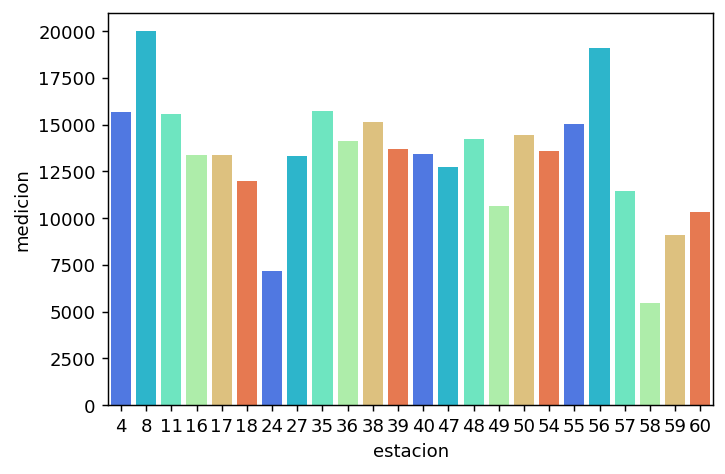

In [33]:
palette = sns.color_palette("rainbow")
sns.barplot(x='estacion', y='medicion', data=df_estaciones24, palette=palette)

En el anterior grafico explicamos cuales son las estaciones que producen mayor contaminacion por NO2 en un año (no he considerado usar la media, si no el total producido por cada estacion en un año para no malinterpretar la informacion)

Por cuestion de optimización y simplifacion del analisis, no tendremos en cuenta para las predicciones y modelos las estaciones donde se recolectan las mediciones, si no que tomaremos una vision global de la provincia (Madrid), Nota: Si es necesario hacerlo se comenta

In [34]:
df_no2_final = df_no2_final.drop(['estacion'], axis=1)

In [35]:
df_no2_dia = df_no2_final.resample('D').sum()

In [36]:
df_no2_dia

,medicion
fecha,
2018-01-01,555.0
2018-01-02,799.0
2018-01-03,931.0
2018-01-04,749.0
2018-01-05,702.0
...,...
2018-12-27,1578.0
2018-12-28,1273.0
2018-12-29,949.0


In [37]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':10}

Text(0, 0.5, 'Medicion diaria total (NO2)')

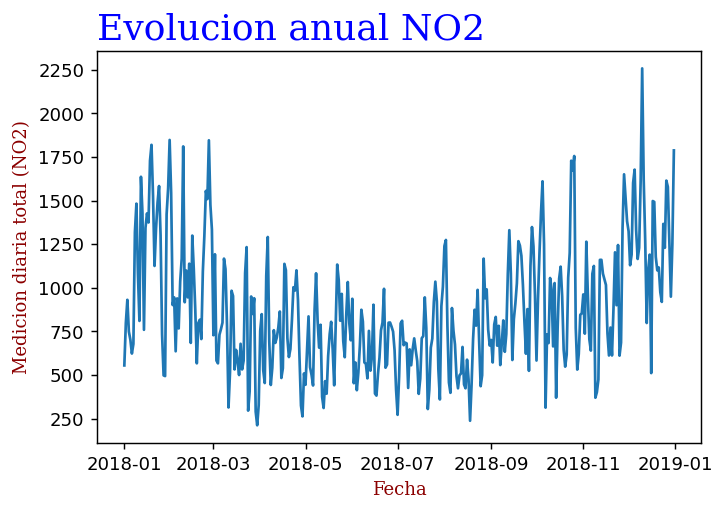

In [38]:
plt.plot(df_no2_dia)
plt.title('Evolucion anual NO2', loc="left", fontdict = font1)
plt.xlabel('Fecha', fontdict = font2)
plt.ylabel('Medicion diaria total (NO2)', fontdict = font2)

Text(0, 0.5, 'Temperatura')

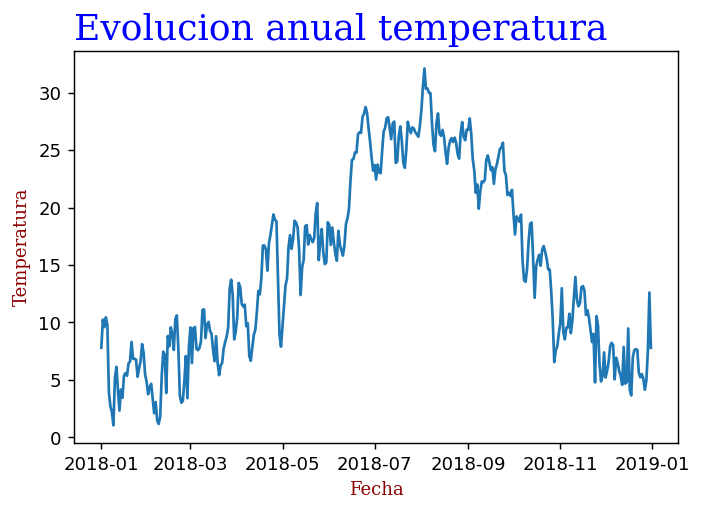

In [39]:
plt.plot(df_temperature_media)
plt.title('Evolucion anual temperatura', loc='left', fontdict = font1)
plt.xlabel('Fecha', fontdict = font2)
plt.ylabel('Temperatura', fontdict = font2)

En los dos anteriores graficos hemos dibujado tanto la temperatura media en madrid en el año 2018 como la contaminacion de N02 en el aire
- Entendemos una correlacion negativa entre ambas variables, a menor temperatura mejora la calidad del aire, lo comprobaremos analiticamente

- El NO2 proviene principalmente de la oxidacion del NO, cuya principal fuente son los automoviles es importante recalcar un aspecto negativo en la salud directamente correlacionado con niveles elevados de dicho elementos. 
- Este descenso en los meses de verano puede comprenderse por la despoblacion de Madrid, segun el ayuntamiento de Madrid , 6 de cada 10 madrileños salen de vacaciones en verano
- Tambien puede deberse ese aumento del NO2 en estaciones mas frias por la sobrepoblacion que sufre Madrid

Unimos ambos data frame para obtener una correlacion entre contaminacion y temperatura

In [40]:
df_union = df_no2_dia.merge(df_temperature_media, how='inner', on='fecha')

In [41]:
df_union

,medicion,temperatura
fecha,,
2018-01-01,555.0,7.787500
2018-01-02,799.0,10.237500
2018-01-03,931.0,9.587500
2018-01-04,749.0,10.437500
2018-01-05,702.0,9.775000
...,...,...
2018-12-27,1578.0,4.133333
2018-12-28,1273.0,4.945833
2018-12-29,949.0,7.495833


In [42]:
column_1 = df_union['medicion']
column_2 = df_union['temperatura']
correlacion = column_2.corr(column_1)
correlacion 

-0.3930889038031797

Existe correlacion negativa como ya hemos observado en el gráfico

# Modelaje

En este apartado se procedera a la separacion de los datos en train y test,  luego se programaran algunos modelos predictivos univariantes o algoritmos, solo tendremos en consideracion la 'medicion'

In [43]:
df_no2_dia = df_no2_dia.loc['2018-01-01':'2018-12-31']
fin_train = '2018-10-01'

y_train = df_no2_dia.loc[: fin_train, :]
y_test  = df_no2_dia.loc[fin_train:, :]

print(f"Fechas train      : {y_train.index.min()} --- {y_train.index.max()}")
print(f"Fechas test       : {y_test.index.min()} --- {y_test.index.max()}")

Fechas train      : 2018-01-01 00:00:00 --- 2018-10-01 00:00:00
Fechas test       : 2018-10-01 00:00:00 --- 2018-12-31 00:00:00


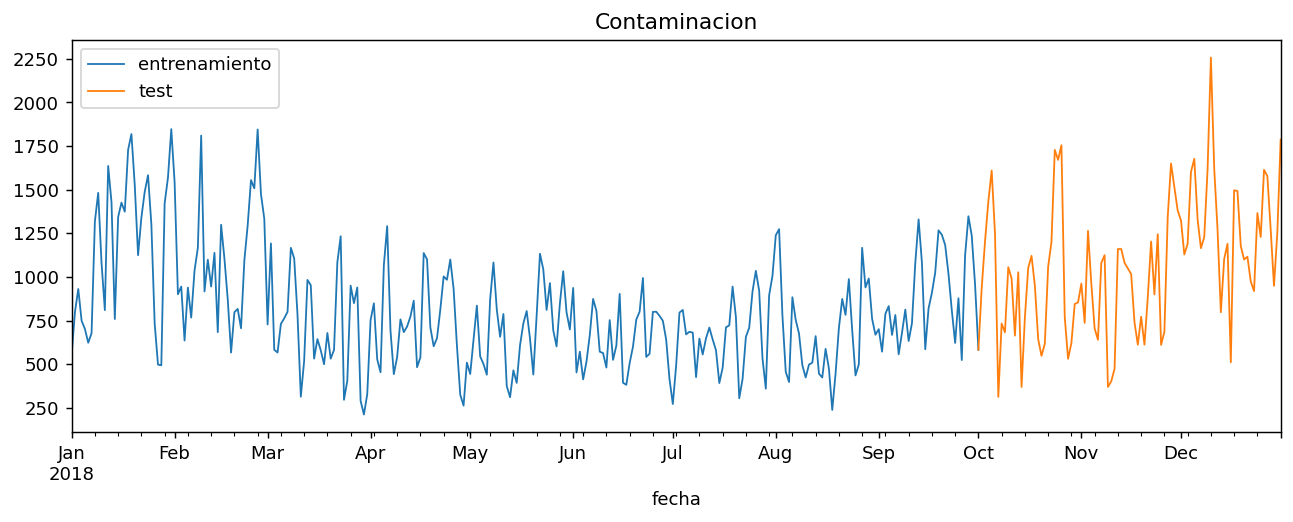

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
y_train.medicion.plot(ax=ax, label='entrenamiento', linewidth=1)
y_test.medicion.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Contaminacion')
ax.legend();

Estudiamos la estacionariedad de la serie para poder decidir que algoritmo predictivo utilizar

In [45]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(df_no2_dia)


Results of Dickey-Fuller Test:
Test Statistic                  -3.031500
p-value                          0.032056
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


Como el p-value<0,05, rechamos la hipotesis nula por lo tanto nuestra serie es estacionaria

## ETS
- Aplicaremos este modelo de aproximacion para la prediccion, no hemos aplicado logaritmos por que el propio algoritmo posee algun componente de suavizado
- Usamos un forecast debido a que tenemos una serie historica, de datos pasados predecimos acontecimientos en el futuro

In [46]:
fh = np.arange(len(y_test)) + 1 # forecasting horizon
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92])

In [47]:
fh = np.arange(len(y_test))
ETS = AutoETS(auto=True, sp=7, n_jobs=-1)

Caclulamos la media y varianza de los datos de entrenamiento

In [48]:
ETS.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=7)

In [49]:
print(ETS.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  274
Model:                       ETS(MNM)   Log Likelihood               -1882.478
Date:                Fri, 11 Feb 2022   AIC                           3786.955
Time:                        16:07:06   BIC                           3826.699
Sample:                    01-01-2018   HQIC                          3802.907
                         - 10-01-2018   Scale                            0.093
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.2770      0.057      4.818      0.000       0.164       0.390
smoothing_seasonal   7.23e-05        nan        nan        nan         nan         nan
initial_level       

In [50]:
ETS_pred = ETS.predict(fh)
print(ETS_pred)

               medicion
2018-10-01  1163.569341
2018-10-02  1076.923890
2018-10-03  1063.684391
2018-10-04  1126.904213
2018-10-05  1120.390008
...                 ...
2018-12-27  1126.904213
2018-12-28  1120.390008
2018-12-29   820.895654
2018-12-30   734.945129
2018-12-31  1002.727173

[92 rows x 1 columns]


(<Figure size 2080x520 with 1 Axes>, <AxesSubplot:>)

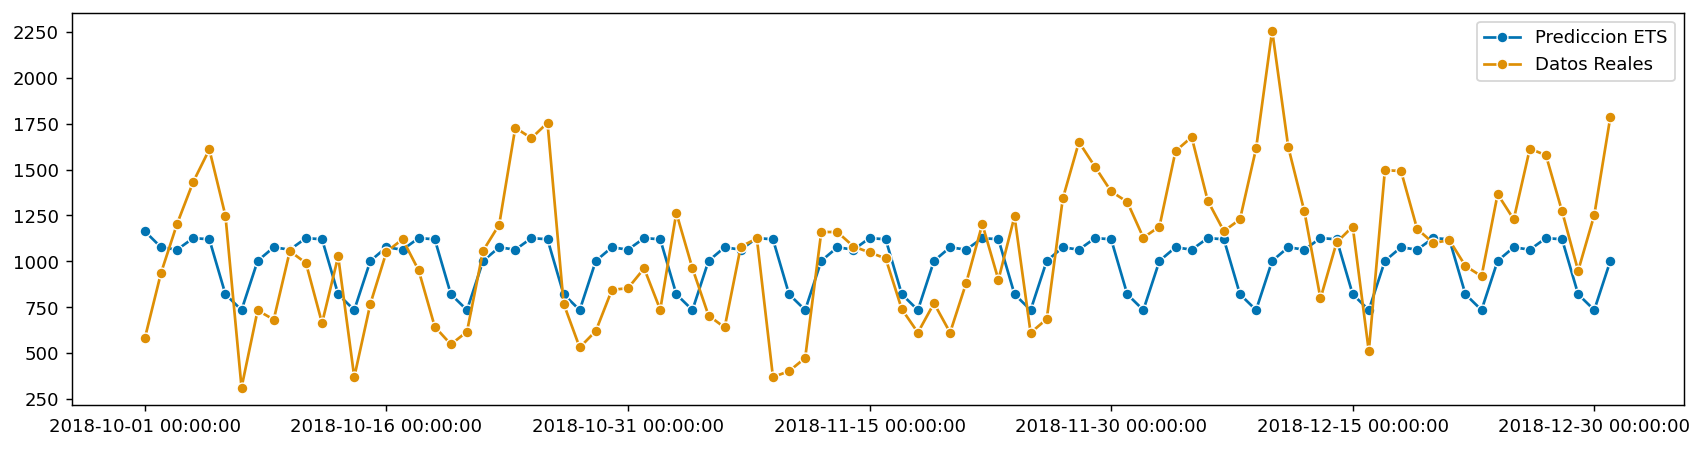

In [51]:
plot_series(ETS_pred, y_test, labels=[ "Prediccion ETS", "Datos Reales"])

A simple vista parece que el error es acusado, la prediccion no se ajusta bien a los valores reales por lo que presuponemos una mal estimacion del test

Lo confirmamos estudiando el MAPE:

In [52]:
mape_ETS = mean_absolute_percentage_error(y_test, ETS_pred)
print('tenemos un MAPE del', mape_ETS)

tenemos un MAPE del 0.29638101860393734


tenemos un 29,63% de error en la prediccion del test

# RandomForestRegressor

Seleccionamos los mejores hiperparametros con un grid_search

In [55]:

# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=0),
                lags      = 14 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [12, 14]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = y_train['medicion'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 91,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(y_train)*0.5),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.11s/it]

Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  params: {'max_depth': 10, 'n_estimators': 100}



In [56]:
# Crear y entrenar forecaster con mejores hiperparámetros
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 12
             )
forecaster.fit(y=y_train['medicion'])

In [57]:
steps = 91
predicciones = forecaster.predict(steps=steps)
predicciones

2018-10-02    676.527695
2018-10-03    807.416353
2018-10-04    817.614372
2018-10-05    816.325320
2018-10-06    856.125984
                 ...    
2018-12-27    753.948747
2018-12-28    759.244747
2018-12-29    757.319376
2018-12-30    759.244747
2018-12-31    757.319376
Freq: D, Name: pred, Length: 91, dtype: float64

Se podria hacer un mejor fine tuning del modelo y conseguir asi mejores predicciones

# Prediccion de tres dias

In [58]:
fh = np.arange(len(y_test)) + 3
ETS = AutoETS(auto=True, sp=7, n_jobs=-1)
ETS.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=7)

In [59]:
ETS_pred = ETS.predict(fh)
print(ETS_pred)

               medicion
2018-10-04  1126.904213
2018-10-05  1120.390008
2018-10-06   820.895654
2018-10-07   734.945129
2018-10-08  1002.727173
...                 ...
2018-12-30   734.945129
2018-12-31  1002.727173
2019-01-01  1076.923890
2019-01-02  1063.684391
2019-01-03  1126.904213

[92 rows x 1 columns]


(<Figure size 2080x520 with 1 Axes>, <AxesSubplot:>)

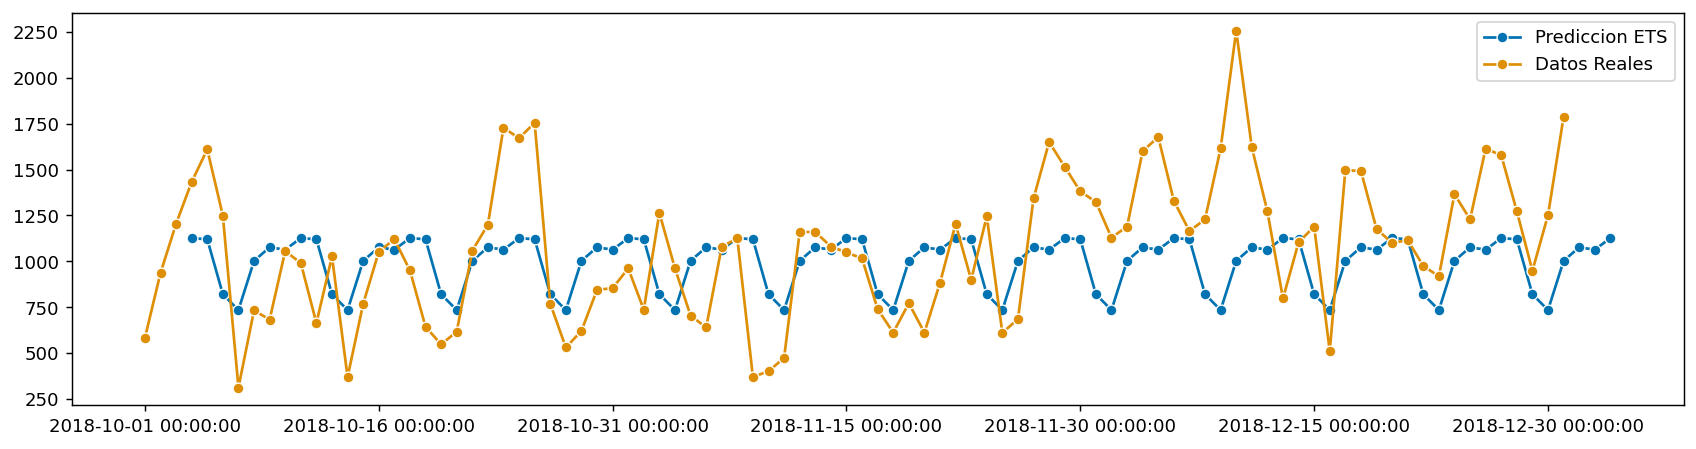

In [60]:
plot_series(ETS_pred, y_test, labels=[ "Prediccion ETS", "Datos Reales"])

In [61]:
Prediccion_tres_dias = ETS_pred.tail(3)

Guardamos en un csv la prediccion para que otros departamentos puedan acceder a ella facilmente, tambien se podrian guardar los modelos en un 'pickle'

In [62]:
df = pd.DataFrame(Prediccion_tres_dias)
df.to_csv('prediccion_tres_dias.csv')

In [63]:
df_export = df_union.to_csv('df.csv')

En conclusion:
- Hemos realizado la limpieza de los datos y transformado la base de datos para que se pueda trabajar con ella de una forma mas eficiente
- Implementamos dos modelos pero se pueden mejorar en distintos aspectos, regresivos, hiperparametros...
- Hemos visto que algunas estaciones captan mayor concentracion de NO2 en el aire, se podria crear un mapa con las distintas regiones de madrid y observar que zona se ven mas perjudicadas
- Hemos encontrado correlacion negativa entre temperatura y NO2 en el aire, también hemos puesto sobre la mesa posibles causas a este fenomenos
- A la hora de predecir podriamos tener en cuenta la temperatura e implementarla al modelo. ¿Posible modelo GARCH multivariante?